In [1]:
import sys
import os

src_path = os.path.split(os.getcwd())[0]
sys.path.insert(0, src_path)

import json
import logging
import numpy as np
import pandas as pd
from pathlib import Path, PurePath
from collections import OrderedDict
from itertools import chain

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import clip.clip as clip
from training.datasets import CellPainting
from clip.clip import _transform
from clip.model import convert_weights, CLIPGeneral
from tqdm import tqdm

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

from sklearn.metrics import accuracy_score, top_k_accuracy_score

from huggingface_hub import hf_hub_download

In [2]:
FILENAME = "cloome-retrieval-zero-shot.pt"
REPO_ID = "anasanchezf/cloome"
checkpoint_path = hf_hub_download(REPO_ID, FILENAME)

In [3]:
# CLOOB
model = "RN50"
image_resolution = 520
img_path = "/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz"

mol_path = '/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/morgan_chiral_fps_P102785.hdf5'
val = '/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/metadata_P102785.csv'

#mol_path = '/share/data/analyses/silvija/RT/data_cloome/our_images/morgan_fingerprint_v2.h5'             # Version before preprocessing_molecules.ipynb

#mol_path = '/share/data/analyses/silvija/RT/data_cloome/our_images/morgan_chiral_fps.hdf5'               # Used for 6 samples
#val = '/share/data/analyses/silvija/RT/data_cloome/our_images/metadata_try_v5.csv'

#mol_path = "morgan_chiral_fps_1024.hdf5"
#val = "cellpainting-test-phenotype-imgpermol.csv"
#classes = "cellpainting-split-test-imgpermol.csv"

In [4]:
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad:
            p.grad.data = p.grad.data.float()

In [5]:
def load(model_path, device, model, image_resolution):

    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    state_dict = checkpoint["state_dict"]

    model_config_file = os.path.join(src_path, f"training/model_configs/{model.replace('/', '-')}.json")

    print(f"\nload()\n\tLoading model from {model_config_file}")
    assert os.path.exists(model_config_file)
    with open(model_config_file, 'r') as f:
        model_info = json.load(f)
    model = CLIPGeneral(**model_info)

    if str(device) == "cpu":
        model.float()
    print(f"\tdevice = {device}")

    new_state_dict = {k[len('module.'):]: v for k,v in state_dict.items()}

    model.load_state_dict(new_state_dict)
    model.to(device)
    model.eval()

    return model, _transform(image_resolution, image_resolution,  is_train=False)

In [6]:
def get_features(dataset, model, device):
    all_image_features = []
    all_text_features = []
    all_ids = []

  #  print(f"get_features {device}")
  #  print(f"len(dataset/val) = {len(dataset)}")
  #  print(f"type of dataset = {type(dataset)}")
  #  print(f"Check if CellPaining is a subclass of Dataset= {issubclass(CellPainting, torch.utils.data.Dataset)}")   # As it is true than DataLoader does not have problem
    

    with torch.no_grad():
        for batch in tqdm(DataLoader(dataset)): #, num_workers=20, batch_size=64
            #print(mols)
            imgs, mols = batch

            images, mols = imgs["input"], mols["input"]
            ids = imgs["ID"]

      #      print(f"get_features()\n\tImages : {imgs}\n\tMols : {mols}\n\tIDs : {ids}")
            
            img_features = model.encode_image(images.to(device))
            text_features = model.encode_text(mols.to(device))

            img_features = img_features / img_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            all_image_features.append(img_features)
            all_text_features.append(text_features)
            all_ids.append(ids)

        all_ids = list(chain.from_iterable(all_ids))
    return torch.cat(all_image_features), torch.cat(all_text_features), all_ids

In [7]:
"""
    print("CellPainting .......... \n")
    print(dir(val))  
    print(f"Dataset size: {len(val)}")
    sample = val[0]  
    
    print(sample)
    
    print("Structure and types of the returned sample : ")  
    if isinstance(sample[0], dict):
        print("First dictionary (image data):")
        for key, value in sample[0].items():
            print(f"\t{key}: {type(value)}, shape: {getattr(value, 'shape', 'Not applicable')}")
    if isinstance(sample[1], dict):
        print("\nSecond dictionary (molecular data):")
        for key, value in sample[1].items():
            print(f"\t{key}: {type(value)}, shape: {getattr(value, 'shape', 'Not applicable')}")
"""    

def main(df, model_path, model, img_path, mol_path, image_resolution):
    # Load the model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"torch.cuda.device_count() = {torch.cuda.device_count()}")

    model, preprocess = load(model_path, device, model, image_resolution)

    preprocess_train = _transform(image_resolution, image_resolution, is_train=True)
    preprocess_val = _transform(image_resolution, image_resolution, is_train=False, normalize="dataset", preprocess="downsize")

    # Load the dataset
    val = CellPainting(df,
                       img_path,
                       mol_path,
                       transforms = preprocess_val)

    sample = val[0]  
 #   print(f"main()\n\tSample : {sample}")
    
    # Calculate the image features
    print("\n\ngetting_features")
    val_img_features, val_text_features, val_ids = get_features(val, model, device)
    
    return val_img_features, val_text_features, val_ids

In [ ]:
# ME 
val_img_features, val_text_features, val_ids = main(val, checkpoint_path, model, img_path, mol_path, image_resolution)

In [9]:
val_img_features = val_img_features.cpu()

In [10]:
val_img_features.shape

torch.Size([2385, 512])

In [11]:
val_img_features

tensor([[ 0.0594, -0.0234, -0.0251,  ..., -0.0255, -0.0273, -0.0273],
        [ 0.0545, -0.0220, -0.0301,  ..., -0.0314, -0.0253, -0.0298],
        [ 0.0457, -0.0141, -0.0226,  ..., -0.0206, -0.0235, -0.0137],
        ...,
        [ 0.0520, -0.0872, -0.0335,  ...,  0.0083, -0.0071,  0.0074],
        [ 0.0502,  0.0048, -0.0182,  ..., -0.0222, -0.0240, -0.0148],
        [ 0.0421, -0.0513, -0.0341,  ..., -0.0148, -0.0109, -0.0112]])

In [12]:
val_df = pd.read_csv(val)
val_df.set_index("SAMPLE_KEY", inplace=True)
val_inchis = val_df.loc[val_ids]["INCHIKEY"]

In [13]:
val_inchis

SAMPLE_KEY
P102785-A09-5    BBDGBGOVJPEFBT-UHFFFAOYSA-N
P102785-L02-9    UHAXDAKQGVISBZ-UHFFFAOYSA-N
P102785-L24-6    SDGJBAUIGHSMRI-UHFFFAOYSA-N
P102785-A03-4    UHAXDAKQGVISBZ-UHFFFAOYSA-N
P102785-G23-2    VUIRVWPJNKZOSS-UHFFFAOYSA-N
                            ...             
P102785-B06-6    BCZUAADEACICHN-UHFFFAOYSA-N
P102785-A08-8    XAPVAKKLQGLNOY-UHFFFAOYSA-N
P102785-F04-5    NQQBNZBOOHHVQP-UHFFFAOYSA-N
P102785-I21-6    BKCDJTRMYWSXMC-UHFFFAOYSA-N
P102785-M02-9    QFJCIRLUMZQUOT-HPLJOQBZSA-N
Name: INCHIKEY, Length: 2385, dtype: object

In [39]:
val_img_features

tensor([[ 0.0594, -0.0234, -0.0251,  ..., -0.0255, -0.0273, -0.0273],
        [ 0.0545, -0.0220, -0.0301,  ..., -0.0314, -0.0253, -0.0298],
        [ 0.0457, -0.0141, -0.0226,  ..., -0.0206, -0.0235, -0.0137],
        ...,
        [ 0.0520, -0.0872, -0.0335,  ...,  0.0083, -0.0071,  0.0074],
        [ 0.0502,  0.0048, -0.0182,  ..., -0.0222, -0.0240, -0.0148],
        [ 0.0421, -0.0513, -0.0341,  ..., -0.0148, -0.0109, -0.0112]])

In [44]:
val_df

,PLATE_ID,WELL_POSITION,SITE,CPD_NAME,CPD_NAME_TYPE,SMILES,INCHIKEY,IMG_ERSyto,IMG_ERSytoBleed,IMG_Hoechst,IMG_Mito,IMG_Ph_golgi
SAMPLE_KEY,,,,,,,,,,,,
P102785-A03-1,P102785,A03,1,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,A03_s1_x0_y0_Fluorescence_488_nm_Ex.tiff,A03_s1_x0_y0_Fluorescence_730_nm_Ex.tiff,A03_s1_x0_y0_Fluorescence_405_nm_Ex.tiff,A03_s1_x0_y0_Fluorescence_638_nm_Ex.tiff,A03_s1_x0_y0_Fluorescence_561_nm_Ex.tiff
P102785-A03-2,P102785,A03,2,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,A03_s2_x1_y0_Fluorescence_488_nm_Ex.tiff,A03_s2_x1_y0_Fluorescence_730_nm_Ex.tiff,A03_s2_x1_y0_Fluorescence_405_nm_Ex.tiff,A03_s2_x1_y0_Fluorescence_638_nm_Ex.tiff,A03_s2_x1_y0_Fluorescence_561_nm_Ex.tiff
P102785-A03-3,P102785,A03,3,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,A03_s3_x2_y0_Fluorescence_488_nm_Ex.tiff,A03_s3_x2_y0_Fluorescence_730_nm_Ex.tiff,A03_s3_x2_y0_Fluorescence_405_nm_Ex.tiff,A03_s3_x2_y0_Fluorescence_638_nm_Ex.tiff,A03_s3_x2_y0_Fluorescence_561_nm_Ex.tiff
P102785-A03-4,P102785,A03,4,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,A03_s4_x0_y1_Fluorescence_488_nm_Ex.tiff,A03_s4_x0_y1_Fluorescence_730_nm_Ex.tiff,A03_s4_x0_y1_Fluorescence_405_nm_Ex.tiff,A03_s4_x0_y1_Fluorescence_638_nm_Ex.tiff,A03_s4_x0_y1_Fluorescence_561_nm_Ex.tiff
P102785-A03-5,P102785,A03,5,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,A03_s5_x1_y1_Fluorescence_488_nm_Ex.tiff,A03_s5_x1_y1_Fluorescence_730_nm_Ex.tiff,A03_s5_x1_y1_Fluorescence_405_nm_Ex.tiff,A03_s5_x1_y1_Fluorescence_638_nm_Ex.tiff,A03_s5_x1_y1_Fluorescence_561_nm_Ex.tiff
...,...,...,...,...,...,...,...,...,...,...,...,...
P102785-P23-5,P102785,P23,5,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,P23_s5_x1_y1_Fluorescence_488_nm_Ex.tiff,P23_s5_x1_y1_Fluorescence_730_nm_Ex.tiff,P23_s5_x1_y1_Fluorescence_405_nm_Ex.tiff,P23_s5_x1_y1_Fluorescence_638_nm_Ex.tiff,P23_s5_x1_y1_Fluorescence_561_nm_Ex.tiff
P102785-P23-6,P102785,P23,6,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,P23_s6_x2_y1_Fluorescence_488_nm_Ex.tiff,P23_s6_x2_y1_Fluorescence_730_nm_Ex.tiff,P23_s6_x2_y1_Fluorescence_405_nm_Ex.tiff,P23_s6_x2_y1_Fluorescence_638_nm_Ex.tiff,P23_s6_x2_y1_Fluorescence_561_nm_Ex.tiff
P102785-P23-7,P102785,P23,7,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,P23_s7_x0_y2_Fluorescence_488_nm_Ex.tiff,P23_s7_x0_y2_Fluorescence_730_nm_Ex.tiff,P23_s7_x0_y2_Fluorescence_405_nm_Ex.tiff,P23_s7_x0_y2_Fluorescence_638_nm_Ex.tiff,P23_s7_x0_y2_Fluorescence_561_nm_Ex.tiff


In [54]:
# Converting features from tensor to dataframe
val_img_features_array = val_img_features.numpy()
val_img_features_df = pd.DataFrame(val_img_features_array)
#val_img_features_df

# Picking columns from metadata that are needed
columns_to_select = ["WELL_POSITION", "SITE", "CPD_NAME", "CPD_NAME_TYPE", "INCHIKEY"]
from_val = val_df.loc[val_ids, columns_to_select]
from_val["SAMPLE_KEY"] = from_val.index
columns = ['SAMPLE_KEY'] + [col for col in from_val.columns if col != 'SAMPLE_KEY']
from_val = from_val[columns]

from_val = from_val.reset_index(drop=True)
val_img_features_df = val_img_features_df.reset_index(drop=True)

val_img_feat_df = pd.concat([from_val, val_img_features_df], axis = 1)

val_img_feat_df

,SAMPLE_KEY,WELL_POSITION,SITE,CPD_NAME,CPD_NAME_TYPE,INCHIKEY,0,1,2,3,...,502,503,504,505,506,507,508,509,510,511
0,P102785-A09-5,A09,5,CBK293873,Skepinone-L,BBDGBGOVJPEFBT-UHFFFAOYSA-N,0.059440,-0.023439,-0.025119,0.009667,...,0.019431,0.005902,0.047129,0.029979,-0.042098,-0.007239,0.020856,-0.025527,-0.027342,-0.027304
1,P102785-L02-9,L02,9,CBK290225,PD 198306,UHAXDAKQGVISBZ-UHFFFAOYSA-N,0.054487,-0.022002,-0.030087,0.020037,...,0.021196,0.001004,0.034690,0.036728,-0.037594,-0.008391,0.026740,-0.031414,-0.025343,-0.029794
2,P102785-L24-6,L24,6,CBK293882,WZ 4003,SDGJBAUIGHSMRI-UHFFFAOYSA-N,0.045698,-0.014116,-0.022616,0.023445,...,0.019792,0.003408,0.054034,0.047287,-0.032704,-0.008509,0.032549,-0.020583,-0.023491,-0.013742
3,P102785-A03-4,A03,4,CBK290225,PD 198306,UHAXDAKQGVISBZ-UHFFFAOYSA-N,0.041484,-0.002545,-0.024327,0.006670,...,0.026746,0.005004,0.043364,0.048906,-0.034178,-0.016586,0.021839,-0.028929,-0.033941,-0.019107
4,P102785-G23-2,G23,2,CBK303906,ML-323,VUIRVWPJNKZOSS-UHFFFAOYSA-N,0.067930,-0.075698,-0.029311,0.007927,...,-0.034757,-0.006516,0.050980,0.012707,-0.032486,0.004832,0.046598,0.011308,-0.007736,0.005897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380,P102785-B06-6,B06,6,CBK288271,SGX 523,BCZUAADEACICHN-UHFFFAOYSA-N,0.067217,-0.044596,-0.029418,0.000188,...,0.002749,0.007100,0.041112,0.036547,-0.030399,-0.005626,0.021710,-0.015866,-0.025929,-0.005733
2381,P102785-A08-8,A08,8,CBK308283,ML 298 hydrochloride,XAPVAKKLQGLNOY-UHFFFAOYSA-N,0.052731,-0.070061,-0.040546,-0.040875,...,-0.026430,-0.006322,0.047905,0.004713,-0.027606,0.022232,0.053421,-0.003046,0.003924,0.000653
2382,P102785-F04-5,F04,5,CBK290309,SU 3327,NQQBNZBOOHHVQP-UHFFFAOYSA-N,0.052001,-0.087197,-0.033517,0.007977,...,-0.036758,-0.004162,0.042821,0.019855,-0.022351,0.006639,0.055666,0.008288,-0.007070,0.007362
2383,P102785-I21-6,I21,6,CBK301244,A 366,BKCDJTRMYWSXMC-UHFFFAOYSA-N,0.050218,0.004797,-0.018191,0.044917,...,0.035366,0.004456,0.052574,0.064465,-0.038407,-0.005924,0.029554,-0.022158,-0.024030,-0.014816


In [ ]:
dfDMSO = val_img_feat_df[df_merged3['batch_id'] == 'DMSO']  # Calculate median values for DMSO
dfDMSO_Medians = dfDMSO[varying_features].median()

In [14]:
from sklearn.manifold import TSNE
features_embedded = TSNE(n_components=2, learning_rate='auto',
                     init='random', metric="cosine", random_state=1, n_jobs=1).fit_transform(val_img_features)

/home/jovyan/share/data/analyses/silvija/RT/conda/envs/cloome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.pyplot import figure
%matplotlib inline

In [16]:
import random

def generate_color():
    for i in range(3):
        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)
        rgb = np.array([r,g,b])/255
        return rgb
    
def gen_color_list(n):
    lst = []
    for i in range(n):
        rgb = generate_color()
        lst.append(rgb)
    return lst

#print(len(set(subset_val["INCHIKEY"])))
subset_val = val_df

In [17]:
def ordered_color_list(df, colors, group_dict):
    n_molecules = len(group_dict)

  #  scaled_colors = np.array(colors)/255

    #groups = df.groupby(group).groups

    ordered_colors = np.zeros((len(df), 3))

    print(f"len of group dictionary = {len(group_dict)}")
    

    for i, (group, indices) in enumerate(group_dict.items()): 
        ordered_colors[indices] = list(colors[i][:3])
        
    #ordered_colors = ordered_colors/255
    return ordered_colors

In [18]:
def plot(features, colors, method):
    
    figure(figsize=(10, 8), dpi=100)

    plt.scatter(features[:, 0], features[:, 1], c=colors)
    
    method_list = [word for word in method.split()]
    method_string = "_".join(method_list)
    method, color_scheme = method_list
    
    plt.title(f"{method} embeddings (coloured by {color_scheme})")
    
    plt.tick_params(
    axis="both",       # changes apply to both axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelbottom=False,
    labeltop=False,
    labelleft=False)
    
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")

        
    plt.show()

def morgan_from_smiles(smiles, radius=3, nbits=1024, chiral=True):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=nbits, useChirality=chiral)
    arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp,arr)
    return arr

def cellpainting_to_rgb(arr):
    arr0 = arr[:, :, 0].astype(np.float32)
    arr3 = arr[:, :, 3].astype(np.float32)
    arr4 = arr[:, :, 4].astype(np.float32)

    rgb_arr = np.dstack((arr0, arr3, arr4))
    
    return rgb_arr.astype(int)

def merge_imgs(mol_img_array, cell_img_array):
    new_im = np.full([mol_img_array.shape[0] + cell_img_array.shape[0], cell_img_array.shape[1], 3], 255, dtype=int)


    new_im[:cell_img_array.shape[0], :cell_img_array.shape[1]] = cell_img_array
    new_im[cell_img_array.shape[0]:, 198:-198] = mol_img_array

    return new_im

In [19]:
# first create a dict with an id (plate or molecule) and theis corresponding sample ids
# then make second dict with id (plate or molecule) and indexes in the array of embeddings
def find_order_by_group(ids_array, df, group):

    dict_ = {}
    val_ids = np.array(ids_array)

    for inchi in df.groupby(group).groups:
       # sample_keys = list(df[df[group] == inchi]["SAMPLE_KEY"])
        inchi_df = df[df["INCHIKEY"] == inchi]
        inchi_df = inchi_df.copy()
        inchi_df.loc[:,'SAMPLE_KEY'] = (inchi_df['PLATE_ID'].astype(str) + '-' + 
                                inchi_df['WELL_POSITION'].astype(str) + '-' + 
                                inchi_df['SITE'].astype(str))
        sample_keys = list(inchi_df["SAMPLE_KEY"])
        dict_[inchi] = sample_keys

    dict_index = {}

    for inchi, ids in dict_.items():
        for i in ids:
            if i in val_ids:
                index = np.where(val_ids == i)[0][0]
                dict_index.setdefault(inchi, []).append(index)
                
    return dict_index


len of group dictionary = 20


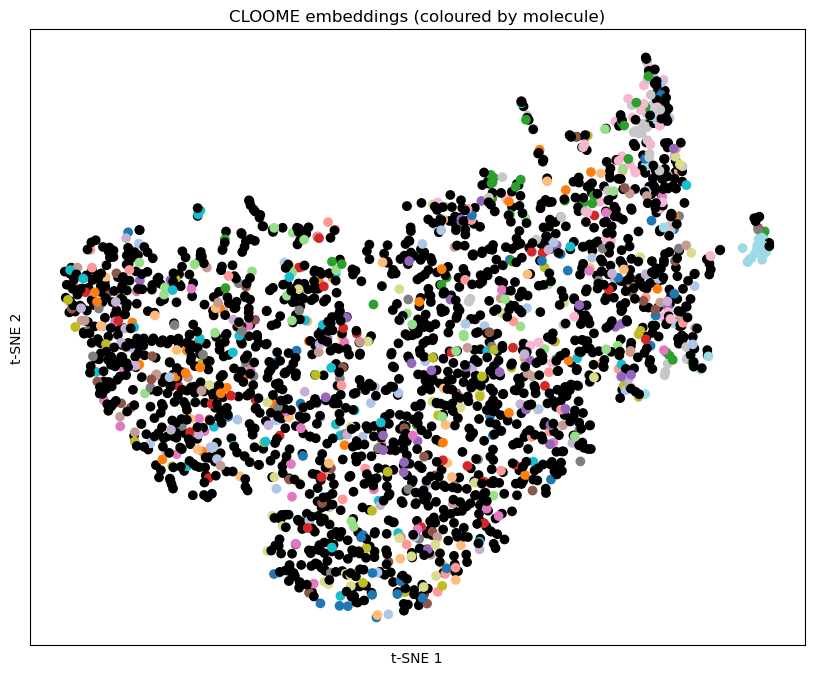

In [20]:
color_list = cm.tab20.colors
np_inchi_id = find_order_by_group(val_ids, subset_val, "INCHIKEY")
np_inchi_id_subset = dict(list(np_inchi_id.items())[20:40])

ordered_colors_mol = ordered_color_list(subset_val, color_list, np_inchi_id_subset)
plot(features_embedded, ordered_colors_mol, "CLOOME molecule")

len of group dictionary = 67


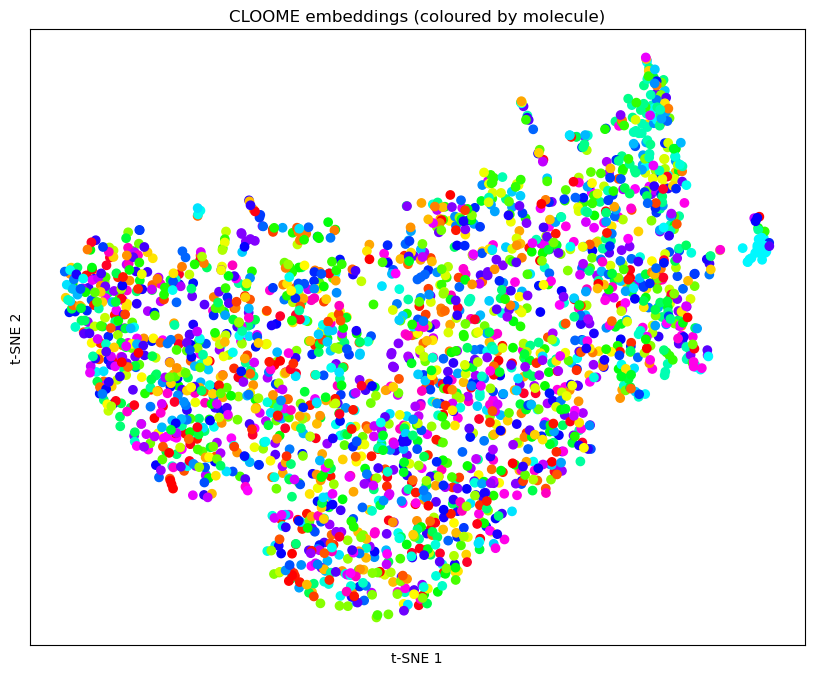

In [21]:
#color_list = cm.tab20.colors
#color_list = cm.get_cmap('tab20', 67)
color_map = cm.get_cmap('gist_rainbow', 67)
color_list = [color_map(i) for i in range(67)] 
np_inchi_id = find_order_by_group(val_ids, subset_val, "INCHIKEY")
ordered_colors_mol = ordered_color_list(subset_val, color_list, np_inchi_id)
plot(features_embedded, ordered_colors_mol, "CLOOME molecule")

In [22]:
pd.read_csv(val)

,SAMPLE_KEY,PLATE_ID,WELL_POSITION,SITE,CPD_NAME,CPD_NAME_TYPE,SMILES,INCHIKEY,IMG_ERSyto,IMG_ERSytoBleed,IMG_Hoechst,IMG_Mito,IMG_Ph_golgi
0,P102785-A03-1,P102785,A03,1,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,A03_s1_x0_y0_Fluorescence_488_nm_Ex.tiff,A03_s1_x0_y0_Fluorescence_730_nm_Ex.tiff,A03_s1_x0_y0_Fluorescence_405_nm_Ex.tiff,A03_s1_x0_y0_Fluorescence_638_nm_Ex.tiff,A03_s1_x0_y0_Fluorescence_561_nm_Ex.tiff
1,P102785-A03-2,P102785,A03,2,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,A03_s2_x1_y0_Fluorescence_488_nm_Ex.tiff,A03_s2_x1_y0_Fluorescence_730_nm_Ex.tiff,A03_s2_x1_y0_Fluorescence_405_nm_Ex.tiff,A03_s2_x1_y0_Fluorescence_638_nm_Ex.tiff,A03_s2_x1_y0_Fluorescence_561_nm_Ex.tiff
2,P102785-A03-3,P102785,A03,3,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,A03_s3_x2_y0_Fluorescence_488_nm_Ex.tiff,A03_s3_x2_y0_Fluorescence_730_nm_Ex.tiff,A03_s3_x2_y0_Fluorescence_405_nm_Ex.tiff,A03_s3_x2_y0_Fluorescence_638_nm_Ex.tiff,A03_s3_x2_y0_Fluorescence_561_nm_Ex.tiff
3,P102785-A03-4,P102785,A03,4,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,A03_s4_x0_y1_Fluorescence_488_nm_Ex.tiff,A03_s4_x0_y1_Fluorescence_730_nm_Ex.tiff,A03_s4_x0_y1_Fluorescence_405_nm_Ex.tiff,A03_s4_x0_y1_Fluorescence_638_nm_Ex.tiff,A03_s4_x0_y1_Fluorescence_561_nm_Ex.tiff
4,P102785-A03-5,P102785,A03,5,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,A03_s5_x1_y1_Fluorescence_488_nm_Ex.tiff,A03_s5_x1_y1_Fluorescence_730_nm_Ex.tiff,A03_s5_x1_y1_Fluorescence_405_nm_Ex.tiff,A03_s5_x1_y1_Fluorescence_638_nm_Ex.tiff,A03_s5_x1_y1_Fluorescence_561_nm_Ex.tiff
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380,P102785-P23-5,P102785,P23,5,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,P23_s5_x1_y1_Fluorescence_488_nm_Ex.tiff,P23_s5_x1_y1_Fluorescence_730_nm_Ex.tiff,P23_s5_x1_y1_Fluorescence_405_nm_Ex.tiff,P23_s5_x1_y1_Fluorescence_638_nm_Ex.tiff,P23_s5_x1_y1_Fluorescence_561_nm_Ex.tiff
2381,P102785-P23-6,P102785,P23,6,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,P23_s6_x2_y1_Fluorescence_488_nm_Ex.tiff,P23_s6_x2_y1_Fluorescence_730_nm_Ex.tiff,P23_s6_x2_y1_Fluorescence_405_nm_Ex.tiff,P23_s6_x2_y1_Fluorescence_638_nm_Ex.tiff,P23_s6_x2_y1_Fluorescence_561_nm_Ex.tiff
2382,P102785-P23-7,P102785,P23,7,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,P23_s7_x0_y2_Fluorescence_488_nm_Ex.tiff,P23_s7_x0_y2_Fluorescence_730_nm_Ex.tiff,P23_s7_x0_y2_Fluorescence_405_nm_Ex.tiff,P23_s7_x0_y2_Fluorescence_638_nm_Ex.tiff,P23_s7_x0_y2_Fluorescence_561_nm_Ex.tiff
2383,P102785-P23-8,P102785,P23,8,CBK290225,PD 198306,Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F,UHAXDAKQGVISBZ-UHFFFAOYSA-N,P23_s8_x1_y2_Fluorescence_488_nm_Ex.tiff,P23_s8_x1_y2_Fluorescence_730_nm_Ex.tiff,P23_s8_x1_y2_Fluorescence_405_nm_Ex.tiff,P23_s8_x1_y2_Fluorescence_638_nm_Ex.tiff,P23_s8_x1_y2_Fluorescence_561_nm_Ex.tiff


In [23]:
vall = '/share/data/analyses/silvija/RT/data_cloome/our_images/cellpainting-all-imgpermol-template.csv'

pd.read_csv(vall).dtypes

Unnamed: 0          int64
Unnamed: 0.1        int64
SAMPLE_KEY         object
BROAD_ID           object
PLATE_ID            int64
WELL_POSITION      object
SITE                int64
SAMPLE_ID          object
CPD_NAME           object
CPD_NAME_TYPE      object
SMILES             object
INCHIKEY           object
IMG_ERSyto         object
IMG_ERSytoBleed    object
IMG_Hoechst        object
IMG_Mito           object
IMG_Ph_golgi       object
IMG_CNT_CELLS       int64
dtype: object

In [24]:
pd.read_csv(val).dtypes

SAMPLE_KEY         object
PLATE_ID           object
WELL_POSITION      object
SITE                int64
CPD_NAME           object
CPD_NAME_TYPE      object
SMILES             object
INCHIKEY           object
IMG_ERSyto         object
IMG_ERSytoBleed    object
IMG_Hoechst        object
IMG_Mito           object
IMG_Ph_golgi       object
dtype: object

In [25]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

# Step 1: Define the SMILES string
smiles = "Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F"

# Step 2: Convert the SMILES string to an RDKit molecule object
mol = Chem.MolFromSmiles(smiles)

# Step 3: Generate the 1024-bit Morgan fingerprint with a radius of 3, including chirality
fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=1024, useChirality=True)

# Step 4: Convert the fingerprint to a numpy array
arr = np.zeros((1024,), dtype=np.int8)
DataStructs.ConvertToNumpyArray(fingerprint, arr)

# Step 5: Create a pandas DataFrame
df = pd.DataFrame([arr], columns=[f'bit_{i}' for i in range(1024)])
#df['SMILES'] = smiles  # Optionally include the SMILES string in the DataFrame
df['SAMPLE_KEY'] = 'P102785-A03-1'  # Optionally include the SMILES string in the DataFrame
df['SAMPLE_KEY'] = df['SAMPLE_KEY'].astype(str)
# Step 6: Save the DataFrame to an HDF5 file
hdf5_filename = '/share/data/analyses/silvija/RT/data_cloome/our_images/morgan_fingerprint_v2.h5'
df.to_hdf(hdf5_filename, key='df', mode='w')
display(df.dtypes)#.astype())

display(df)

print(f"1024-bit Morgan fingerprint saved to {hdf5_filename}")


bit_0          int64
bit_1          int64
bit_2          int64
bit_3          int64
bit_4          int64
               ...  
bit_1020       int64
bit_1021       int64
bit_1022       int64
bit_1023       int64
SAMPLE_KEY    object
Length: 1025, dtype: object

,bit_0,bit_1,bit_2,bit_3,bit_4,bit_5,bit_6,bit_7,bit_8,bit_9,...,bit_1015,bit_1016,bit_1017,bit_1018,bit_1019,bit_1020,bit_1021,bit_1022,bit_1023,SAMPLE_KEY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,P102785-A03-1


1024-bit Morgan fingerprint saved to /share/data/analyses/silvija/RT/data_cloome/our_images/morgan_fingerprint_v2.h5


In [26]:
# Loading the HDF5 file
hdf5_filename = '/share/data/analyses/silvija/RT/data_cloome/our_images/morgan_chiral_fps.hdf5'
#hdf5_filename = '/share/data/analyses/silvija/RT/data_cloome/our_images/morgan_fingerprint_v2.h5'

df_loaded = pd.read_hdf(hdf5_filename, key='df')

# Display the loaded DataFrame
print(df_loaded.head())


               0  1  2  3  4  5  6  7  8  9  ...  1015  1016  1017  1018  \
ID                                           ...                           
P102785-A03-1  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
P102785-A04-1  0  1  0  0  0  0  0  0  0  1  ...     0     0     0     0   
P102785-A07-1  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
P102785-A08-1  0  0  0  0  0  0  0  0  1  0  ...     0     0     0     0   
P102785-A09-1  0  0  0  1  0  0  0  0  0  0  ...     0     0     0     0   

               1019  1020  1021  1022  1023     SAMPLE_KEY  
ID                                                          
P102785-A03-1     1     0     0     0     0  P102785-A03-1  
P102785-A04-1     0     0     0     0     0  P102785-A04-1  
P102785-A07-1     0     0     0     0     0  P102785-A07-1  
P102785-A08-1     0     0     0     0     0  P102785-A08-1  
P102785-A09-1     0     0     0     1     0  P102785-A09-1  

[5 rows x 1025 columns]


In [27]:
# ME : converts png to npz

import os
import numpy as np
from PIL import Image

def convert_png_to_npz(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for file_name in os.listdir(input_dir):
        if file_name.endswith('.png'): 
            png_path = os.path.join(input_dir, file_name)
            npz_path = os.path.join(output_dir, os.path.splitext(file_name)[0] + '.npz')
            
            image = Image.open(png_path)
            image_array = np.array(image)
            np.savez(npz_path, sample=image_array)
            
            print(f"Converted {file_name} to {npz_path}")

# Example usage
input_directory = '/share/data/analyses/silvija/RT/data_cloome/our_images/channels'  # Replace with the path to DirA
output_directory = '/share/data/analyses/silvija/RT/data_cloome/our_images/channels_npz'  # Replace with the path to DirB

convert_png_to_npz(input_directory, output_directory)


Converted img_P102785_acqid_4359_A03_site_1_merged_channel_2.png to /share/data/analyses/silvija/RT/data_cloome/our_images/channels_npz/img_P102785_acqid_4359_A03_site_1_merged_channel_2.npz
Converted img_P102785_acqid_4359_A03_site_1_merged_channel_3.png to /share/data/analyses/silvija/RT/data_cloome/our_images/channels_npz/img_P102785_acqid_4359_A03_site_1_merged_channel_3.npz
Converted img_P102785_acqid_4359_A03_site_1_merged_channel_1.png to /share/data/analyses/silvija/RT/data_cloome/our_images/channels_npz/img_P102785_acqid_4359_A03_site_1_merged_channel_1.npz
Converted img_P102785_acqid_4359_A03_site_1_merged_channel_5.png to /share/data/analyses/silvija/RT/data_cloome/our_images/channels_npz/img_P102785_acqid_4359_A03_site_1_merged_channel_5.npz
Converted img_P102785_acqid_4359_A03_site_1_merged_channel_4.png to /share/data/analyses/silvija/RT/data_cloome/our_images/channels_npz/img_P102785_acqid_4359_A03_site_1_merged_channel_4.npz
Converted P102785-A03-1.png to /share/data/an

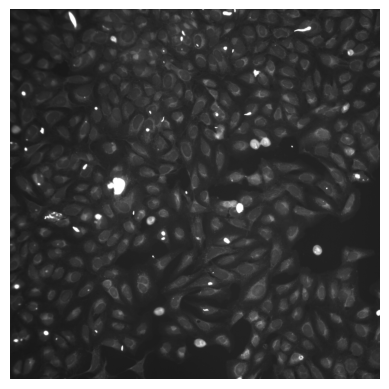

In [28]:
#ME : to check if it works
import numpy as np
import matplotlib.pyplot as plt

npz_file_path = '/share/data/analyses/silvija/RT/data_cloome/our_images/channels_npz/img_P102785_acqid_4359_A03_site_1_merged_channel_4.npz'
npz_data = np.load(npz_file_path)

image_array = npz_data['sample']        # Extracting image array

plt.imshow(image_array)
plt.axis('off')                              # Hide the axes for a cleaner look
plt.show()


In [29]:
import pandas as pd

# Load the CSV file
csv_file_path = '/share/data/analyses/silvija/RT/data_cloome/our_images/metadata_try_v2.csv' 
df = pd.read_csv(csv_file_path)

df_modified = df.iloc[:, 2:]
new_csv_file_path = '/share/data/analyses/silvija/RT/data_cloome/our_images/metadata_try_v3.csv'
df_modified.to_csv(new_csv_file_path, index=False)

print(f"New CSV file saved at {new_csv_file_path}")


New CSV file saved at /share/data/analyses/silvija/RT/data_cloome/our_images/metadata_try_v3.csv


In [30]:
import os
import numpy as np
from PIL import Image

def convert_png_to_npz(input_dir, output_dir, channels):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop over all samples (assuming one file per channel)
    sample_names = set([file_name.split('_')[0] for file_name in os.listdir(input_dir) if file_name.endswith('.png')])

    for sample_name in sample_names:
        channel_images = []
        
        for channel in range(1, channels + 1):                         # Loop over all channel files for the sample
            channel_file = f"{sample_name}_channel{channel}.png"
            png_path = os.path.join(input_dir, channel_file)
            
            if os.path.exists(png_path):
                image = Image.open(png_path)
                image_array = np.array(image)
                channel_images.append(image_array)
            else:
                print(f"WARNING: Channel file {channel_file} not found for sample {sample_name}")
                continue
        
        # Stack all channel images along the third dimension
        if channel_images:
            multi_channel_image = np.stack(channel_images, axis=-1)
            
            # Save the multi-channel image as an .npz file
            npz_path = os.path.join(output_dir, f"{sample_name}.npz")
            np.savez(npz_path, sample=multi_channel_image)
            
            print(f"Converted {sample_name} to {npz_path} with {len(channel_images)} channels")
        else:
            print(f"WARNING: No channels found for sample {sample_name}")

input_directory = '/share/data/analyses/silvija/RT/data_cloome/our_images/channels' 
output_directory = '/share/data/analyses/silvija/RT/data_cloome/our_images/single_npz' 
channels = 5

convert_png_to_npz(input_directory, output_directory, channels)


In [ ]:
val_img_features, val_text_features, val_ids = main(val, checkpoint_path, model, img_path, mol_path, image_resolution)
class_img_features, class_text_features, class_ids = main(classes, checkpoint_path, model, img_path, mol_path, image_resolution)
val_img_features = val_img_features.cpu()
class_img_features = class_img_features.cpu()

In [ ]:
val_img_features.shape

In [ ]:
classes_df = pd.read_csv(classes)
classes_df.set_index("SAMPLE_KEY", inplace=True)
class_inchis = classes_df.loc[class_ids]["INCHIKEY"]

In [ ]:
val_df = pd.read_csv(val)
val_df.set_index("SAMPLE_KEY", inplace=True)

In [ ]:
val_df

In [ ]:
val_inchis = val_df.loc[val_ids]["INCHIKEY"]

In [ ]:
class_dict = {}

for i, inchi in enumerate(class_inchis): 
    class_dict[inchi] = i

In [ ]:
ground_truth = np.zeros(len(val_inchis), dtype=int)

for i, inchi in enumerate(val_inchis): 
    label = class_dict[inchi]
    ground_truth[i] = int(label)

In [ ]:
# Calculating accuracies in several ways

# WAY 1
logits = val_img_features @ class_img_features.T
acc = accuracy_score(ground_truth, logits.argmax(axis=1)) * 100.0
print(acc)

In [ ]:
# WAY 2
N = ground_truth.shape[0]
(np.array(ground_truth) == logits.argmax(axis=1).numpy()).sum() / N * 100

In [ ]:
# WAY 3
ranking = torch.argsort(logits, descending=True)
t = torch.tensor(ground_truth, dtype=torch.int16).view(-1,1)

preds = torch.where(ranking == t)[1]
preds = preds.detach().cpu().numpy()

metrics = {}
for k in [1, 5, 10]:
    metrics[f"R@{k}"] = np.mean(preds < k) * 100
    
print(metrics)

In [ ]:
# WAY 4
probs = (val_img_features @ class_img_features.T).softmax(dim=-1)

metrics_skl = {}
for k in [1, 5, 10]:
    metrics_skl[f"R@{k}"] = top_k_accuracy_score(ground_truth, probs, k=k) * 100
    
print(metrics_skl)

In [ ]:
from scipy.stats import binomtest

n_samples = val_img_features.shape[0]

mdict, cis = {}, {}

for metric, value in metrics.items():
    successes = int(value * n_samples / 100)
    btest = binomtest(k=successes, n=n_samples)
    mdict[metric] = btest.proportion_estimate * 100
    cis[metric] = btest.proportion_ci(confidence_level=0.95)
    
print(mdict)
print(cis)